In [8]:
%pip install tensorflow==2.8.3 tensorflow_datasets matplotlib numpy==1.26.3 opencv-python tf-explain saliency

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 3.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 7.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np

from tensorflow.keras.models import Sequential, load_model
import tensorflow_datasets as tfds
import tensorflow as tf

image_shape = (224, 224, 3)

# Load the Food101 dataset
dataset, info = tfds.load('food101', with_info=True,
                          as_supervised=True, shuffle_files=True)

# Split the dataset into training and testing sets
train_dataset = dataset['train']
test_dataset = dataset["validation"]

2024-12-03 14:34:30.570963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-03 14:34:30.570994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/lars/development/DHBW/XAI/XAI-Projekt/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-03 14:34:38.572275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-12-03 14:34:38.572347: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UN

In [2]:
# preprocess images

from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout,
    BatchNormalization,
    RandomFlip,
    RandomRotation,
    RandomZoom,
    RandomContrast,
    Rescaling,
    Resizing
)


def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label


train_dataset = train_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [ ]:
# train model
from tensorflow.keras.optimizers import Adam

augmentation = Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomContrast(0.2),
    ]
)

model = Sequential(
    [
        Input(image_shape),
        augmentation,
        Rescaling(1.0 / 255),
        Resizing(224, 224),
        Conv2D(32, (3, 3), strides=(2, 2), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Resizing(112, 112),
        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation="relu"),
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation="relu"),
        Conv2D(64, (3, 3), activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation="relu"),
        Conv2D(128, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(101, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()
model.fit(train_dataset.batch(32), epochs=20,
          validation_data=test_dataset.batch(32))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resizing_2 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 111, 111, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                  

KeyboardInterrupt: 

In [7]:
# save model

model.save("models/food101_model_v3_0.h5")

In [5]:
# load model
model_loaded: Sequential = load_model("models/food101_model_v3_0.h5")
model_loaded.summary()
#model_loaded.evaluate(test_dataset.batch(5))

# model_loaded.fit(train_dataset.batch(200), epochs=10, validation_data=test_dataset.batch(200))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resizing_4 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 111, 111, 32)      896       
                                                                 
 batch_normalization_20 (Bat  (None, 111, 111, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                  

In [ ]:
# save model
model.save("models/food101_model_v3_0.h5")

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


def resize_images(image, label):
    image = tf.image.resize(image, size=(224, 224))
    image = tf.cast(image, dtype=tf.float32)
    return image, label


train_data = dataset['train'].map(
    map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(
    batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# test_data doesn't need to be shuffled
test_data = dataset['validation'].map(
    map_func=resize_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size=32).prefetch(
    buffer_size=tf.data.AUTOTUNE)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False)
base_model.trainable = False

inputs = Input(shape=(224, 224, 3), name='inputLayer')
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='poolingLayer')(x)
x = Dense(101, name='outputLayer')(x)
outputs = tf.keras.layers.Activation(
    activation="softmax", dtype=tf.float32, name='activationLayer')(x)

finetuned_model = tf.keras.Model(
    inputs, outputs, name="FeatureExtractionModel")

finetuned_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

finetuned_model.fit(train_data,
                    epochs=1,
                    steps_per_epoch=0.1*len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.1 * len(test_data))
                    )

236/236 [==============================] - 44s 172ms/step - loss: 3.0817 - accuracy: 0.3298 - val_loss: 2.0672 - val_accuracy: 0.5447


In [ ]:
# save fine-tuned model

finetuned_model.save("models/food101_model_fine_tuned0.h5")

In [20]:
model_loaded_pretrained = tf.keras.models.load_model(
    "models/food101_model_fine_tuned0.h5")
model_loaded_pretrained.summary()

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


TypeError: SparseCategoricalCrossentropy.__init__() got an unexpected keyword argument 'ignore_class'

In [ ]:
# XRAI Verfahren
# !pip install saliency

import saliency.core as saliency

class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx = call_model_args[class_idx_str]
    model = call_model_args["model"]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

ValueError: num must be an integer with 1 <= num <= 1, not 2

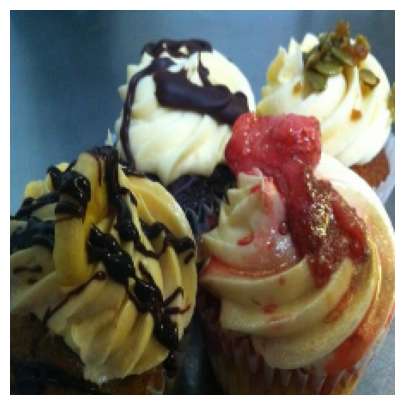

In [ ]:
# grad cam
import cv2
from tf_explain.core.grad_cam import GradCAM
import matplotlib.pyplot as plt

def predict_imgs(images, model):
    prediction = model.predict(images)
    predicted_class_idx = np.argmax(prediction, axis=1)
    return predicted_class_idx


def explain_gradCAM(image, model, layer_name, predicted_class_idx):
    gradCAM = GradCAM()
    explained_img = gradCAM.explain(
        validation_data=(image, None),
        model=model,
        layer_name=layer_name,
        class_index=predicted_class_idx,
        colormap=cv2.COLORMAP_VIRIDIS,
    )
    return explained_img

def explain_xrai(image, model, layer_name, predicted_class_idx):
    conv_layer = model.get_layer(layer_name)
    model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])
    call_model_args = {class_idx_str: predicted_class_idx, "model": model}
    xrai_object = saliency.XRAI()
    xrai_attributions = xrai_object.GetMask(image, call_model_function, call_model_args, batch_size=1)
    return xrai_attributions

def add_row_to_plt(rows, pos, image, model, actual_class, layer_name, predicted_class_idx):
    predicted_class = info.features['label'].names[predicted_class_idx]
    gradcam_img = explain_gradCAM(
        image.reshape(1, 224, 224, 3), model, layer_name, predicted_class_idx)
    xrai_attributions = explain_xrai(image, model, layer_name, predicted_class_idx)
    
    plt.subplot(rows, 3, 3*(pos-1) + 1)
    plt.text(0, -5, "Actual Class: " + actual_class +
             "\nPredicted Class: " + predicted_class)
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(rows, 3, 3*(pos-1) + 2)
    plt.axis('off')
    plt.imshow(gradcam_img)
    plt.subplot(rows, 3, 3*(pos-1) + 3)
    plt.axis('off')
    # Show most salient 30% of the image
    xrai_mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
    xrai_im_mask = np.array(image)
    xrai_im_mask[~xrai_mask] = 0
    plt.imshow(xrai_im_mask)


rows = 2

for layer in model_loaded.layers[:: -1]:
        if (layer.name.startswith("conv")):
            layer_name = layer.name
            break
test_imgs, test_classes = next(iter(test_dataset.batch(rows)))
predicted_class_indices = predict_imgs(test_imgs, model_loaded)

# XRAI steps
orig_img = test_imgs[0].numpy().astype(np.uint8)
xrai_attributions = explain_xrai(orig_img, model_loaded, layer_name, predicted_class_indices[i])
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(orig_img)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(xrai_attributions)
plt.subplot(1, 3, 3)
plt.axis('off')
# Show most salient 30% of the image
xrai_mask = xrai_attributions >= np.percentile(xrai_attributions, 70)
xrai_im_mask = np.array(orig_img)
xrai_im_mask[~xrai_mask] = 0
plt.imshow(xrai_im_mask)
plt.show()

plt.figure(figsize=(15, 5*rows))
for i in range(rows):
    test_img = test_imgs[i].numpy().astype(np.uint8)
    test_class = test_classes[i].numpy().astype(np.uint8)
    actual_class = info.features['label'].names[test_class]
        
    add_row_to_plt(rows, i+1, test_img, model_loaded, actual_class, layer_name, predicted_class_indices[i])
plt.show()